# Insurance Pricing Game

## 0. Setup

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
def get_claims_performance(data, by=None):

    claims_columns = ['claim_amount']

    for column in claims_columns:
        if column not in data.columns:
            raise KeyError(f"Key data missing from dataframe: {column}")
    
    if by is None:
        raise TypeError("Argument not passed to 'by', or None passed instead")

    data_claims = data[data['claim_amount'] > 0]
    
    if by is not None:
        data = data.groupby(by)
        data_claims = data_claims.groupby(by)

    policies = data['id_policy'].count()
    incurred = data['claim_amount'].sum()
    claim_count = data_claims['claim_amount'].count()
    avg_claim_amount = data_claims['claim_amount'].mean().round(2)

    data_grouped = pd.DataFrame({"policies": policies, "incurred": incurred, "claim_count":claim_count, "avg_claim_amount":avg_claim_amount})

    data_grouped['frequency'] = (data_grouped['claim_count'] / data_grouped['policies']).round(2)
    data_grouped['burn'] = (data_grouped['incurred'] / data_grouped['policies']).round(2)

    return data_grouped

In [5]:
def get_demographics(data, by=None):
    def get_normalized_proportion(data, nominal, by=None, prefix=None):
        
        if prefix is None:
            prefix = nominal

        unique_list = data[nominal].unique()

        if by is not None:    
            data = data.groupby(by)    

        prop = data[nominal].value_counts(normalize=True).unstack(nominal)
        
        for value in unique_list:
            prop = prop.rename(columns={value:f"{prefix}_{value}"})
        
        return prop
    def policy(data, by):
        age_policy = data.groupby(by)['pol_duration'].mean().round(2)
        staleness = data.groupby(by)['pol_sit_duration'].mean().round(2)
        ncd = data.groupby(by)['pol_no_claims_discount'].mean().round(2)

        usage = get_normalized_proportion(data, 'pol_usage', by=by)
        pay_freq = get_normalized_proportion(data, 'pol_pay_freq', by=by)
        payd = get_normalized_proportion(data, 'pol_payd', by=by)

        data_policy = pd.DataFrame()
        data_policy['avg_age_policy'] = age_policy
        data_policy['avg_staleness_policy'] = staleness
        data_policy['avg_ncd_policy'] = ncd

        data_policy = data_policy.join(usage)
        data_policy = data_policy.join(pay_freq)
        data_policy = data_policy.join(payd)

        return data_policy
        

    def passenger(data, by):
        age_policyholder = data.groupby(by)['drv_age1'].mean().round(2)
        age_additionaldriver = data.groupby(by)['drv_age2'].mean().round(2)
        age_alldrivers = data[[by,'drv_age1']].append(data[[by, 'drv_age2']].rename(columns={"drv_age2":"drv_age1"})).groupby(by).mean().round(2)

        data_passenger = pd.DataFrame()

        data_passenger['avg_age_policyholder'] = age_policyholder
        data_passenger['avg_age_additionaldriver'] = age_additionaldriver
        data_passenger['avg_age_alldrivers'] = age_alldrivers

        return data_passenger

    def vehicle(data, by):

        data_grouped = data.groupby(by)

        age_vehicle = data_grouped['vh_age'].mean().round(2)
        speed_vehicle = data_grouped['vh_speed'].mean().round(2)
        fuel_vehicle = get_normalized_proportion(data, 'vh_fuel', by=by)

        data_vehicle = pd.DataFrame()

        data_vehicle['avg_age_vh'] = age_vehicle
        data_vehicle['avg_speed_vh'] = speed_vehicle

        data_vehicle = data_vehicle.join(fuel_vehicle)

        return data_vehicle

    demo_passenger = passenger(data, by)
    demo_vehicle = vehicle(data, by)
    demo_policy = policy(data, by)
    
    df = demo_policy
    df = df.join(demo_passenger)
    df = df.join(demo_vehicle)    
    return df

In [6]:
def get_everything(data, by):
    d = get_demographics(data, by=by)
    c = get_claims_performance(data, by=by)

    df = c.join(d)

    return df

## 1. Loading and Preprocessing of Data

In [7]:
raw = pd.read_csv("W:/Shared With Me/Gibraltar/OTHER/AI Crowd Competition/Data/training.csv")

In [8]:
data = raw.copy()

## 2. Claims Exploration

Important takeaways so far...

1. No data on what the customer paid for their policy.
2. Book is performing better each year, ensure model doesn't do anything to reverse mix changes.
3. Policyholders (all drivers...) are getting older over the years, as are their vehicles. Not capturing young drivers at same rate.
4. pol_usage, pol_payd, vh_make_model, vh_type, vh_value, vh_speed, vh_fuel, vh_weight proportions do not change over years

In [27]:
print(f"Number of Policies: {len(data)}")
print(f"Number of Policies Claim Free: {len(data[data['claim_amount'] == 0])}")
print(f"Number of Policies with Claim: {len(data[data['claim_amount'] != 0])}")
print(f"Overall Frequency: { round(len(data[data['claim_amount'] != 0]) / len(data),3) * 100 }%")
print(f"Total Incurred: EUR { round(sum(data['claim_amount']),2) } ")

burn_crude = sum(data['claim_amount']) / len(data)
print(f"Crude burn cost: EUR { round(burn_crude, 2) } ")

print(f"Number of Large Losses over EUR 15,000: {len(data[data['claim_amount'] >= 15000])}")

Number of Policies: 228216
Number of Policies Claim Free: 204924
Number of Policies with Claim: 23292
Overall Frequency: 10.2%
Total Incurred: EUR 26057988.08 
Crude burn cost: EUR 114.18 
Number of Large Losses over EUR 25,000: 15


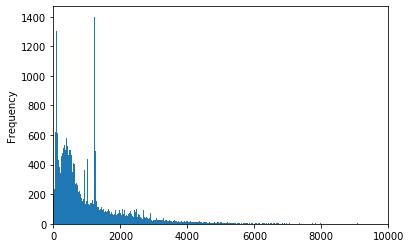

In [22]:
claim_data = data[data['claim_amount'] != 0]
claim_data['claim_amount'].plot(kind='hist', bins=5000, xlim=(0,10000))

In [10]:
data_yearly = get_claims_performance(data, 'year')
data_yearly

,policies,incurred,claim_count,avg_claim_amount,frequency,burn
year,,,,,,
1.0,57054,6806453.23,6280,1083.83,0.11,119.30
2.0,57054,6788036.71,6030,1125.71,0.11,118.98
3.0,57054,6404289.79,5747,1114.37,0.10,112.25
4.0,57054,6059208.35,5235,1157.44,0.09,106.20


In [11]:
data_usage = get_claims_performance(data, 'pol_usage')
data_usage

,policies,incurred,claim_count,avg_claim_amount,frequency,burn
pol_usage,,,,,,
AllTrips,208,72317.31,45,1607.05,0.22,347.68
Professional,16044,2637423.97,2227,1184.29,0.14,164.39
Retired,61988,6875031.45,5836,1178.04,0.09,110.91
WorkPrivate,149976,16473215.35,15184,1084.91,0.10,109.84


In [12]:
get_demographics(data, 'pol_usage')

ValueError: The name pol_usage occurs multiple times, use a level number

In [ ]:
get_everything(data, 'year')

In [ ]:
get_everything(data, 'pol_sit_duration')

In [16]:
get_everything(data, 'year')

,policies,incurred,claim_count,avg_claim_amount,frequency,burn,avg_age_policy,avg_staleness_policy,avg_ncd_policy,pol_usage_AllTrips,...,pol_payd_No,pol_payd_Yes,avg_age_policyholder,avg_age_additionaldriver,avg_age_alldrivers,avg_age_vh,avg_speed_vh,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid
year,,,,,,,,,,,,,,,,,,,,,
1.0,57054,6806453.23,6280,1083.83,0.11,119.30,11.11,2.75,0.05,0.000911,...,0.958285,0.041715,54.84,47.07,52.91,9.64,170.95,0.543082,0.456024,0.000894
2.0,57054,6788036.71,6030,1125.71,0.11,118.98,12.11,3.75,0.05,0.000911,...,0.958285,0.041715,55.84,48.07,53.91,10.64,170.95,0.543082,0.456024,0.000894
3.0,57054,6404289.79,5747,1114.37,0.10,112.25,13.11,4.75,0.04,0.000911,...,0.958285,0.041715,56.84,49.07,54.91,11.64,170.95,0.543082,0.456024,0.000894
4.0,57054,6059208.35,5235,1157.44,0.09,106.20,14.11,5.75,0.04,0.000911,...,0.958285,0.041715,57.84,50.07,55.91,12.64,170.95,0.543082,0.456024,0.000894
